In [34]:
import numpy             as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


from tensorflow.keras.applications import InceptionV3



In [35]:
from google.colab import drive
drive.mount('/content/drive')
!unzip drive/MyDrive/train_data.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  drive/MyDrive/train_data.zip
replace train_data/4/2b6d215d5debf49f4e8b521dfe2e577f2ba287a3_1629111584.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [12]:
import os
from PIL import Image
from collections import Counter

dataset_path = 'train_data'


def get_image_dimensions(image_path):
    with Image.open(image_path) as img:
        return img.size

image_paths = [os.path.join(root, filename) for root, _, filenames in os.walk(dataset_path) for filename in filenames]


image_dimensions = [get_image_dimensions(image_path) for image_path in image_paths]


dimension_counts = Counter(image_dimensions)


most_common_dimension = dimension_counts.most_common(1)[0][0]

image_size = most_common_dimension

print("Most common image dimensions:", image_size)


Most common image dimensions: (456, 456)


In [19]:
dimension_counts

Counter({(456, 456): 9976,
         (455, 456): 2,
         (456, 380): 1,
         (456, 403): 1,
         (456, 430): 1,
         (419, 456): 1,
         (417, 456): 1,
         (398, 456): 1,
         (456, 409): 1,
         (456, 384): 1,
         (426, 456): 1,
         (431, 456): 1,
         (456, 445): 1,
         (399, 456): 1})

In [36]:
image_size =  (456, 456)
batch_size = 32
train_data_dir = 'train_data'
num_classes = 10

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 7994 images belonging to 10 classes.


In [ ]:
def lr_schedule(epoch):
    lr = 1e-1
    if epoch > 7:
      lr *= 1e-4
    elif epoch > 5:
        lr *= 1e-3
    elif epoch > 2:
        lr *= 1e-2
    return lr

In [40]:
epochs = 5
# Load the pre-trained InceptionV3 model without top classification layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.0001, 2, 0.96, staircase=True, name=None)
# Compile the model
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])




In [43]:
# Training

history = model.fit(
    train_generator,
    epochs=epochs,
    verbose=1
)


Epoch 1/5
250/250 [==============================] - 476s 2s/step - loss: 1.3623 - accuracy: 0.5550
Epoch 2/5
250/250 [==============================] - 462s 2s/step - loss: 1.3228 - accuracy: 0.5752
Epoch 3/5
250/250 [==============================] - 460s 2s/step - loss: 1.2960 - accuracy: 0.5838
Epoch 4/5
250/250 [==============================] - 466s 2s/step - loss: 1.2705 - accuracy: 0.5898
Epoch 5/5
250/250 [==============================] - 460s 2s/step - loss: 1.2547 - accuracy: 0.5941


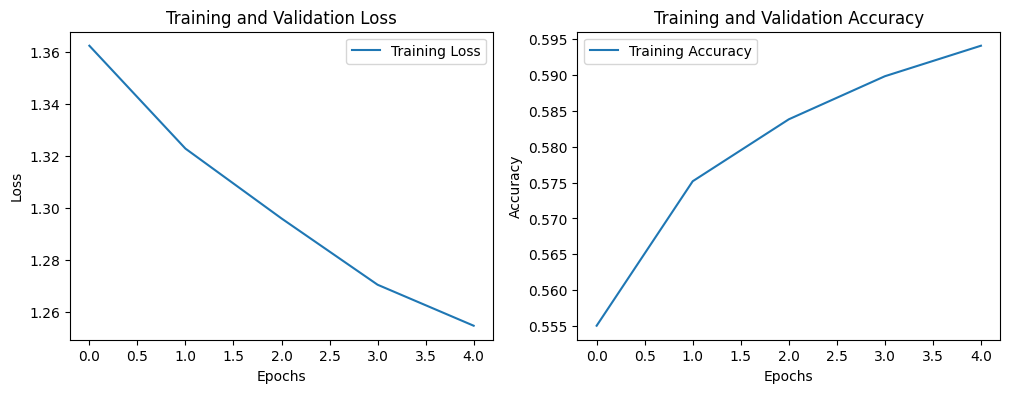

In [46]:
import matplotlib.pyplot as plt


train_loss = history.history['loss']
train_accuracy = history.history['accuracy']


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Training Accuracy')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.show()


In [47]:
# Save the model to a specific directory
model.save('/content/drive/MyDrive/models/my_model.h5')


In [42]:
# Load the saved model
model = keras.models.load_model('/content/drive/MyDrive/models/my_model.h5')

In [48]:
model.evaluate(train_generator)

250/250 [==============================] - 462s 2s/step - loss: 1.1090 - accuracy: 0.6440


[1.1090248823165894, 0.643983006477356]